In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Fluid_CP as FCP #calculation of  thermodynamic states
import plotDiag_Th_Ts as Diag #plot Th diagram with heat sink and heat source
from scipy.optimize import  minimize,NonlinearConstraint #optimization
import Compressormodel_SP as CM
import CoolProp.CoolProp as CP

## Seperately defined functions

In [2]:
def calc_eta(param_calc):
    etas_fun = CM.recip_comp_SP(param_calc,fluid)
    eta_is = etas_fun[0]  # extract isentropic efficiency
    return eta_is

def calc_mdot(param_calc):
    etas_fun = CM.recip_comp_SP(param_calc,fluid)
    m_dot = etas_fun[1]  # extract mass flow rate
    return m_dot

In [3]:
def HP(param):
    
    T_co, T_ev = param

    # Thermodynamic states of the heat pump process
    # State 1*: evaporator: T1 = T_ev and x1 = 1.0 (saturated vapor)
    param_calc = T_ev, T_co, delta_T_sh, None, _D
    
    eta_is = calc_eta(param_calc)
    m_dot = calc_mdot(param_calc)


    # State 1*: saturated vapor at evaporator pressure
    state1_sat = FCP.state(["T", "x"], [T_ev, 1.0], fluid, Eh)

    # State 1: outlet evaporator, superheated vapor if delta_T_sh > 0
    if delta_T_sh > 0.0:
        state1 = FCP.state(["T", "p"], [T_ev + delta_T_sh, state1_sat["p"]], fluid, Eh)
    else:
        state1 = state1_sat

    # State 3*: saturated liquid at condenser outlet temperature
    state3_sat = FCP.state(["T", "x"], [T_co, 0.0], fluid, Eh)

    # State 3: subcooled liquid at condenser outlet
    state3 = FCP.state(["T", "p"], [T_co - delta_T_sc, state3_sat["p"]], fluid, Eh)

    # State 3x: dewpoint at condenser pressure (x = 1)
    state3x = FCP.state(["T", "x"], [T_co, 1.0], fluid, Eh)

    # State 2s: ideal isentropic compression (s2s = s1, p2s = p3)
    state2s = FCP.state(["p", "s"], [state3["p"], state1["s"]], fluid, Eh)

    # h2 from compressor efficiency
    h2 = state1["h"] + (state2s["h"] - state1["h"]) / eta_is

    # State 2: actual compressor outlet
    state2 = FCP.state(["p", "h"], [state3["p"], h2], fluid, Eh)

    # State 4: after expansion valve (isenthalpic), p4 = p1, h4 = h3
    state4 = FCP.state(["p", "h"], [state1["p"], state3["h"]], fluid, Eh)

    

    return {
        "state1_sat": state1_sat,
        "state1": state1,
        "state2s": state2s,
        "state2": state2,
        "state3_sat": state3_sat,
        "state3": state3,
        "state3x": state3x,
        "state4": state4,
        "h2": h2,
        "eta_is": eta_is,
        "m_dot": m_dot
    }

In [4]:
def calc_COP(param): 
    hp_vals = HP(param)

    state1 = hp_vals["state1"]

    state3= hp_vals["state3"]

    state2= hp_vals["state2"]

    #spec. heat released in the condenser
    q_high=state2["h"]-state3["h"] #kJ/kg
    #spec. compressor work
    w_comp=state2["h"]-state1["h"]  #kJ/kg
    #coefficient of performance 

    COP=q_high/w_comp
    #return reciprocal value of COP
    return 1./COP

In [5]:
def pinch_evap(param):

    T_co, T_ev = param
    
    hp_vals = HP(param)
    
    ##### Evaporator outlet
    #The temperature difference at the outlet of the evaporator *delta_T_out_ev* is the difference 
    #between the inlet temperature of the source *T_so_in* and the outlet temperature of the refrigerant *T_1*.

    state1 = hp_vals["state1"]

    state4 = hp_vals["state4"]

    delta_T_out_ev=T_so_in-state1["T"]
    
    ##### Evaporator inlet
    #The temperature difference at the inlet of the evaporator *delta_T_in_ev* is the difference 
    #between the outlet temperature of the source *T_so_out* and the inlet temperature of the refrigerant *T_4*. 
    delta_T_in_ev=T_so_out-state4["T"]
    
    #return the values at inlet and outlet as a vector
    return [delta_T_in_ev,delta_T_out_ev]

In [6]:
def pinch_con(param):
    
    T_co, Tev = param

    hp_vals = HP(param)

    state3 = hp_vals["state3"]

    state2 = hp_vals["state2"]

    state3x = hp_vals["state3x"]
    
    ##### Condenser outlet 
    #The temperature difference at the outlet of the condenser *delta_T_out_co* is the difference 
    #between the outlet temperature of the refrigerant *T_3* and the inlet temperature of the sink *T_si_in*.
    delta_T_out_co=state3["T"]-T_si_in

    ##### Condenser inlet
    #The temperature difference at the inlet of the condenser *delta_T_in_co* is the difference 
    #between the inlet temperature of the refrigerant *T_2* and the outlet temperature of the sink *T_si_out*.
    delta_T_in_co=state2["T"]-T_si_out
    
    ##### Dew line condenser (refrigerant)
    #The temperature difference at the inside of the condenser *delta_T_inside_co* is the difference between the condenser
    #temperature *T_con* and the temperature of the heat sink at the dew line of the refrigerant *T_si_inside*.
    
    #enthalpy of the refrigerant at the inlet/outlet of the condenser
    h_out_co=state3["h"]
    h_in_co=state2["h"]
    
    #enthalpy of saturated vapor at T_co and p_co: h_sat_Tco
    h_sat_Tco=state3x["h"]

    #Enthalpies of heat sink 
    h_si_in=FCP.state(["T","p"],[T_si_in,1.0],fluid_si,Eh)["h"]
    h_si_out=FCP.state(["T","p"],[T_si_out,1.0],fluid_si,Eh)["h"]

    #State of the heat sink at the point the refrigerant passes the dew line
    h_si_inside=h_si_out-(h_si_out-h_si_in)/(state2["h"]-state3["h"])*(state2["h"]-h_sat_Tco)
    T_si_inside=FCP.state(["p","h"],[1.0,h_si_inside],fluid_si,Eh)["T"]
    #temperature difference
    delta_T_inside_co=T_co-T_si_inside
    
    #return the values at inlet, outlet, and dew line as a vector
    return [delta_T_in_co,delta_T_out_co,delta_T_inside_co]


In [7]:
#thermal resistance times tube length for convective heat transfer
def calc_RL_conv(h_transfer,d_tube_inner):
    R_L_conv=1./(h_transfer*np.pi*d_tube_inner) #mK/W
    return R_L_conv

#thermal resistance times tube length for conductive heat transfer
def calc_RL_cond(lambda_w,d_w,d_out,d_i):
    R_L_cond= d_w/(lambda_w*((d_out-d_i)/(np.log(d_out/d_i)))*np.pi) #mK/W
    return R_L_cond


In [8]:
def calc_spec_length(param):

    T_co,T_ev =param

    hp_vals = HP(param)

    state2 = hp_vals["state2"]

    state3 = hp_vals["state3"]

    state3_sat = hp_vals["state3_sat"]

    state3x = hp_vals["state3x"]

    h2 = hp_vals["h2"]

    m_dot = hp_vals["m_dot"]
    
    #heat flow condenser
    Q_con_sh = m_dot*(h2-state3x['h']) #kW
    Q_con_lat =m_dot*(state3x["h"]-state3_sat["h"]) #kW
    Q_con_sc = m_dot*(state3_sat['h'] - state3['h']) #kW

    P = (Q_con_lat + Q_con_sc + Q_con_sh) / (1/calc_COP(param))

    print("Heat for condensing superheat=",round(Q_con_sh,2),"kW")
    print("Heat for condensing latent=",round(Q_con_lat,2),"kW")
    print("Heat for condensing subcooling=",round(Q_con_sc,2),"kW")
    print("Heat out= ",round(Q_con_sh+Q_con_lat+Q_con_sc,2),"kW")
    print("Work in= ",round(P,2),"kW")

    
    T3sat = state3_sat['T']
    T3x = state3x['T']
    T2 = state2['T']
    #temperarture of air=constant 
    eps = 1e-20 #to avoid division by zero in logarithm
    T_water_worst_case = T_si_in - eps #T_si_in #can be adjusted, depends on the heatpump design and controlling 
    
    #logarithmic mean temperature difference during condensing, all steps 
    deltaT_m_sc=((T3sat - T_si_in) - ((T3sat - delta_T_sc)- T_si_in))/(np.log((T3sat - T_si_in)/((T3sat - delta_T_sc) - T_si_in )))
    deltaT_m_sh=((T2 - T_water_worst_case) - (T3x - T_water_worst_case))/(np.log((T2 - T_water_worst_case)/(T3x - T_water_worst_case)))

    L_con_sc = Q_con_sc*1000*R_L_sc/(deltaT_m_sc)
    L_con_lat = Q_con_lat*1000*R_L_lat/(T3sat - T_water_worst_case)
    L_con_sh = Q_con_sh*1000*R_L_sh/(deltaT_m_sh)
    
    print("Tube length for condensing superheating= ",round(L_con_sh,2),"m")
    print("Tube length for condensing latent= ",round(L_con_lat,2),"m")
    print("Tube length for condensing subcooling= ",round(L_con_sc,2),"m")
    L_t=L_con_sc+L_con_lat+L_con_sh
    print("Total length of condenser tube=",round(L_t,2),"m")


    return L_t, Q_con_lat + Q_con_sc + Q_con_sh

## Variable definitions

In [9]:
# all the variables and definitions needed for heat pump design
# many global variables also used in the functions


diameters = [35,40,45,50]
refrigerants = ["Isobutane","Butane","Isobutene","DimethylEther"]

#refrigerant
delta_T_sh=10. #K #superheating --> assumption
delta_T_sc=5 #K #subcooling --> assumption
fluid=refrigerants[0]# ---> must be varied 
Eh="CBar"

_D = diameters[0]

#source
fluid_so="air"
T_so_in=20. #°C
T_so_out= T_so_in #°C -> parallel flow, same temperature in and out 

#sink
T_si_in=87
T_si_out= T_si_in
fluid_si="water"

#heat exchanger
min_pinch=0.5 #K -> assumption


h_refVapLiq = 2000 #W/m^2/K
h_refVap = 200 #W/m^2/K
h_refLiq = 1000 #W/m^2/K

stainless_lambda_steel = 15 #W/m/K

d_i = 0.00635 #m
d_out = 0.0055 #m
h_water = 1000 #W/m^2/K
d_w = 0.00635 - 0.0055 #m

max_length_condenser = 66.15

### Calculating thermal resistances

In [10]:
#convective heat transfer inner tube wall
R_L_h_refVap = calc_RL_conv(h_refVap,d_i)
#conductive heat transfer through wall
R_L_lambda_w=calc_RL_cond(stainless_lambda_steel,d_w,d_out,d_i)
#convective heat transfer outer tube wall
R_L_h_water=calc_RL_conv(h_water,d_out)

R_L_sh=R_L_h_refVap+R_L_lambda_w+R_L_h_water
print("thermal resistance per meter during condensation in superheated state=",round(R_L_sh,4),"mK/W")

#convective heat transfer inner tube wall
R_L_h_reflat=calc_RL_conv(h_refVapLiq,d_i)

R_L_lat=R_L_h_reflat+R_L_lambda_w+R_L_h_water
print("thermal resistance per meter during latent=",round(R_L_lat,4),"mK/W")

#convective heat transfer inner tube wall
R_L_h_refLiq=calc_RL_conv(h_refLiq,d_i)

R_L_sc=R_L_h_refLiq+R_L_lambda_w+R_L_h_water
print("thermal resistance per meter during subcooling=",round(R_L_sc,4),"mK/W")

thermal resistance per meter during condensation in superheated state= 0.3116 mK/W
thermal resistance per meter during latent= 0.086 mK/W
thermal resistance per meter during subcooling= 0.1111 mK/W


## Optimization

### Example optimization for single case (fixed: fluid, compressor, T_sink, max_length_condenser)

In [24]:
fluid = "Isobutane"

_D = 40

nominal_Q = 3661.6 / 1000


bounds=[(T_si_in,np.inf),(-np.inf,T_so_in)] #(T_co_min, T_co_max), (T_ev_min, T_ev_max)
#For a function funct with three return values, nonlinear constraints are defined as follows:
#Syntax: NC1=NonlinearConstraint(func, [min_1,min_2,min_3],[max_1,max_2, max_3])
#Define the nonlinear constaints for the approach temperatures: NC1, NC2
NC1=NonlinearConstraint(pinch_evap, [min_pinch,min_pinch],[np.inf,min_pinch])
NC2=NonlinearConstraint(pinch_con, [min_pinch,min_pinch,min_pinch],[np.inf,np.inf,np.inf])
NC3a=NonlinearConstraint(lambda x: [calc_spec_length(x)[0]], [0], [100000])
NC3b = NonlinearConstraint(lambda x: [calc_spec_length(x)[1]], [nominal_Q], [nominal_Q])

#Syntax:  NCs=(NC1, NC2,....)
NCs=[NC1,NC2,NC3a, NC3b]
#Define an appropriate initial guess (starting point).
T_co_start = T_si_in + 10 #°C
T_ev_start = T_so_in - 10 #°C

#Use minimize to optimize the COP
Opti=minimize(calc_COP,x0=[T_co_start, T_ev_start],method='SLSQP',bounds=bounds,constraints=NCs)
#Check if the optimization terminated successfull and print the COP
print("Success optimization=",Opti.success)
COP=1./calc_COP(Opti.x)
print("optimized COP = ",round(COP,2))
#Print the optimized evaporator and condenser temperature: T_ev_op, T_co_op
T_ev_op=Opti.x[1]
T_co_op=Opti.x[0]
print("optimized condensation temperature= ",round(T_co_op,2),"°C")
print("optimized evaporation temperature= ",round(T_ev_op,2),"°C")

c:\Users\aless\anaconda3\envs\SHC\lib\site-packages\scipy\optimize\_minimize.py:665: OptimizeWarning: Equality and inequality constraints are specified in the same element of the constraint list. For efficient use with this method, equality and inequality constraints should be specified in separate elements of the constraint list. 
  constraints = standardize_constraints(constraints, x0, meth)


Heat for condensing superheat= 0.82 kW
Heat for condensing latent= 3.77 kW
Heat for condensing subcooling= 0.28 kW
Heat out=  4.87 kW
Work in=  2.37 kW
Tube length for condensing superheating=  14.67 m
Tube length for condensing latent=  32.44 m
Tube length for condensing subcooling=  4.25 m
Total length of condenser tube= 51.36 m
Heat for condensing superheat= 0.82 kW
Heat for condensing latent= 3.77 kW
Heat for condensing subcooling= 0.28 kW
Heat out=  4.87 kW
Work in=  2.37 kW
Tube length for condensing superheating=  14.67 m
Tube length for condensing latent=  32.44 m
Tube length for condensing subcooling=  4.25 m
Total length of condenser tube= 51.36 m
Heat for condensing superheat= 0.82 kW
Heat for condensing latent= 3.77 kW
Heat for condensing subcooling= 0.28 kW
Heat out=  4.87 kW
Work in=  2.37 kW
Tube length for condensing superheating=  14.67 m
Tube length for condensing latent=  32.44 m
Tube length for condensing subcooling=  4.25 m
Total length of condenser tube= 51.36 m
H

Heat for condensing superheat= 0.87 kW
Heat for condensing latent= 2.52 kW
Heat for condensing subcooling= 0.27 kW
Heat in=  3.66 kW
Work in= 2.3245972880241013
Tube length for condensing superheating=  7.84 m
Tube length for condensing latent=  8.38 m
Tube length for condensing subcooling=  1.27 m
Total length of condenser tube= 17.49 m
optimized condensation temperature=  112.89 °C
optimized evaporation temperature=  9.5 °C


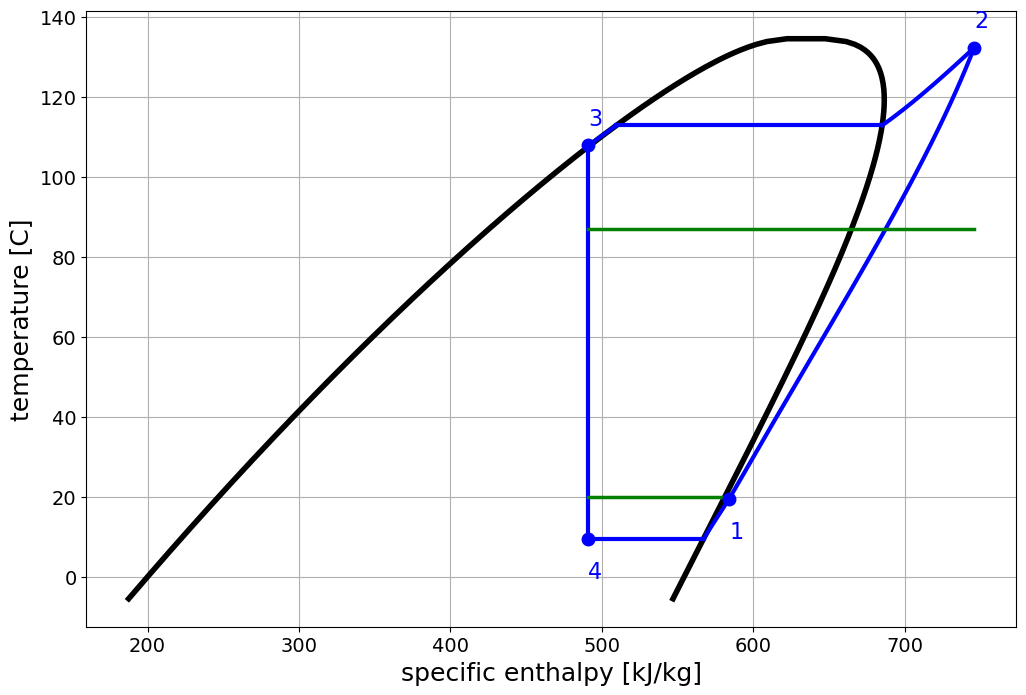

In [25]:
#thermodynamic states of the heat pump process as a function of the optimal evaporation and condensation temperatures
#state1_sat_op: evaporator: T1=T_ev_op and x1=1.0 (saturated vapor)

hp_evals = HP((T_co_op,T_ev_op))

state1_sat_op=hp_evals["state1_sat"]

#state1_op: outlet evaporator: T1=T_ev_op+delta_T_sh and p1=p1_sat
state1_op = hp_evals["state1"]

#state3_sat_op: outlet condenser: T3=T_co_op and x3=0.0 (boiling liquid)
state3_sat_op= hp_evals["state3_sat"]
#state3_op: outlet condenser: T3=T_co_op-delta_T_sc and p3=p3_stat
state3_op= hp_evals["state3"]
# State 3x: dewpoint at condenser pressure (x = 1)

state3x_op = hp_evals["state3x"]

eta_is = hp_evals["eta_is"]
m_dot = hp_evals["m_dot"]

#state2s_op: isentropic compressor: p2s=p_co=p3 and s2s=s1 
state2s_op= hp_evals["state2s"]
#enthalpy h2 is calulated using the compressor efficiency eta_is
h2_op= hp_evals["h2"]
#state2_op: outlet compressor: p2=p_co=p3 and h2
state2_op= hp_evals["state2"]
#state4_op: outlet throttle: p4=p_ev=p1 and h4=h3 (isenthalpic throttle)
state4_op= hp_evals["state4"]

Q_con_sh = m_dot*(h2_op-state3x_op['h']) #kW
Q_con_lat =m_dot*(state3x_op["h"]-state3_sat_op["h"]) #kW
Q_con_sc = m_dot*(state3_sat_op['h'] - state3_op['h'])

P_in = (Q_con_sh + Q_con_lat + Q_con_sc) / COP

print("Heat for condensing superheat=",round(Q_con_sh,2),"kW")
print("Heat for condensing latent=",round(Q_con_lat,2),"kW")
print("Heat for condensing subcooling=",round(Q_con_sc,2),"kW")
print("Heat in= ",round(Q_con_sh+Q_con_lat+Q_con_sc,2),"kW")
print("Work in=", P_in)

T3sat = state3_sat_op['T']
T3x = state3x_op['T']
T2 = state2_op['T']
 
T_water_worst_case = T_si_in 

deltaT_m_sc=((T3sat - T_water_worst_case) - ((T3sat - delta_T_sc)- T_water_worst_case))/(np.log((T3sat - T_water_worst_case)/((T3sat - delta_T_sc) - T_water_worst_case )))
deltaT_m_sh=((T2 - T_water_worst_case) - (T3x - T_water_worst_case))/(np.log((T2 - T_water_worst_case)/(T3x - T_water_worst_case))) 

L_con_sc = Q_con_sc*1000*R_L_sc/(deltaT_m_sc)
L_con_lat = Q_con_lat*1000*R_L_lat/(T3sat - T_water_worst_case)
L_con_sh = Q_con_sh*1000*R_L_sh/(deltaT_m_sh)

print("Tube length for condensing superheating= ",round(L_con_sh,2),"m")
print("Tube length for condensing latent= ",round(L_con_lat,2),"m")
print("Tube length for condensing subcooling= ",round(L_con_sc,2),"m")
L_t=L_con_sc+L_con_lat+L_con_sh
print("Total length of condenser tube=",round(L_t,2),"m")
print("optimized condensation temperature= ",round(T_co_op,2),"°C")
print("optimized evaporation temperature= ",round(T_ev_op,2),"°C")

Diag.Th(state1_op,state2_op,state3_op,state4_op,[T_si_in,T_si_out],[T_so_in,T_so_out],fluid,Eh)

In [20]:
fluid = "Isobutane"

_D = 40

nominal_Q = 3661.6 / 1000


bounds=[(T_si_in,np.inf),(-np.inf,T_so_in)] #(T_co_min, T_co_max), (T_ev_min, T_ev_max)
#For a function funct with three return values, nonlinear constraints are defined as follows:
#Syntax: NC1=NonlinearConstraint(func, [min_1,min_2,min_3],[max_1,max_2, max_3])
#Define the nonlinear constaints for the approach temperatures: NC1, NC2
NC1=NonlinearConstraint(pinch_evap, [min_pinch,min_pinch],[np.inf,min_pinch])
NC2=NonlinearConstraint(pinch_con, [min_pinch,min_pinch,min_pinch],[np.inf,min_pinch,np.inf])
NC3a=NonlinearConstraint(lambda x: [calc_spec_length(x)[0]], [0], [np.inf])
NC3b = NonlinearConstraint(lambda x: [calc_spec_length(x)[1]], [nominal_Q], [nominal_Q])

#Syntax:  NCs=(NC1, NC2,....)
NCs=[NC1,NC2,NC3a, NC3b]
#Define an appropriate initial guess (starting point).
T_co_start = T_si_in + 10 #°C
T_ev_start = T_so_in - 10 #°C

#Use minimize to optimize the COP
Opti=minimize(calc_COP,x0=[T_co_start, T_ev_start],method='SLSQP',bounds=bounds,constraints=NCs)
#Check if the optimization terminated successfull and print the COP
print("Success optimization=",Opti.success)
COP=1./calc_COP(Opti.x)
print("optimized COP = ",round(COP,2))
#Print the optimized evaporator and condenser temperature: T_ev_op, T_co_op
T_ev_op=Opti.x[1]
T_co_op=Opti.x[0]
print("optimized condensation temperature= ",round(T_co_op,2),"°C")
print("optimized evaporation temperature= ",round(T_ev_op,2),"°C")

c:\Users\aless\anaconda3\envs\SHC\lib\site-packages\scipy\optimize\_minimize.py:665: OptimizeWarning: Equality and inequality constraints are specified in the same element of the constraint list. For efficient use with this method, equality and inequality constraints should be specified in separate elements of the constraint list. 
  constraints = standardize_constraints(constraints, x0, meth)


Heat for condensing superheat= 0.82 kW
Heat for condensing latent= 3.77 kW
Heat for condensing subcooling= 0.28 kW
Heat out=  4.87 kW
Work in=  2.37 kW
Tube length for condensing superheating=  14.67 m
Tube length for condensing latent=  32.44 m
Tube length for condensing subcooling=  4.25 m
Total length of condenser tube= 51.36 m
Heat for condensing superheat= 0.82 kW
Heat for condensing latent= 3.77 kW
Heat for condensing subcooling= 0.28 kW
Heat out=  4.87 kW
Work in=  2.37 kW
Tube length for condensing superheating=  14.67 m
Tube length for condensing latent=  32.44 m
Tube length for condensing subcooling=  4.25 m
Total length of condenser tube= 51.36 m
Heat for condensing superheat= 0.82 kW
Heat for condensing latent= 3.77 kW
Heat for condensing subcooling= 0.28 kW
Heat out=  4.87 kW
Work in=  2.37 kW
Tube length for condensing superheating=  14.67 m
Tube length for condensing latent=  32.44 m
Tube length for condensing subcooling=  4.25 m
Total length of condenser tube= 51.36 m
H

Heat for condensing superheat= 0.82 kW
Heat for condensing latent= 3.77 kW
Heat for condensing subcooling= 0.28 kW
Heat in=  4.87 kW
Work in= 2.368465616519178
Tube length for condensing superheating=  14.67 m
Tube length for condensing latent=  32.44 m
Tube length for condensing subcooling=  4.25 m
Total length of condenser tube= 51.36 m
optimized condensation temperature=  97.0 °C
optimized evaporation temperature=  10.0 °C


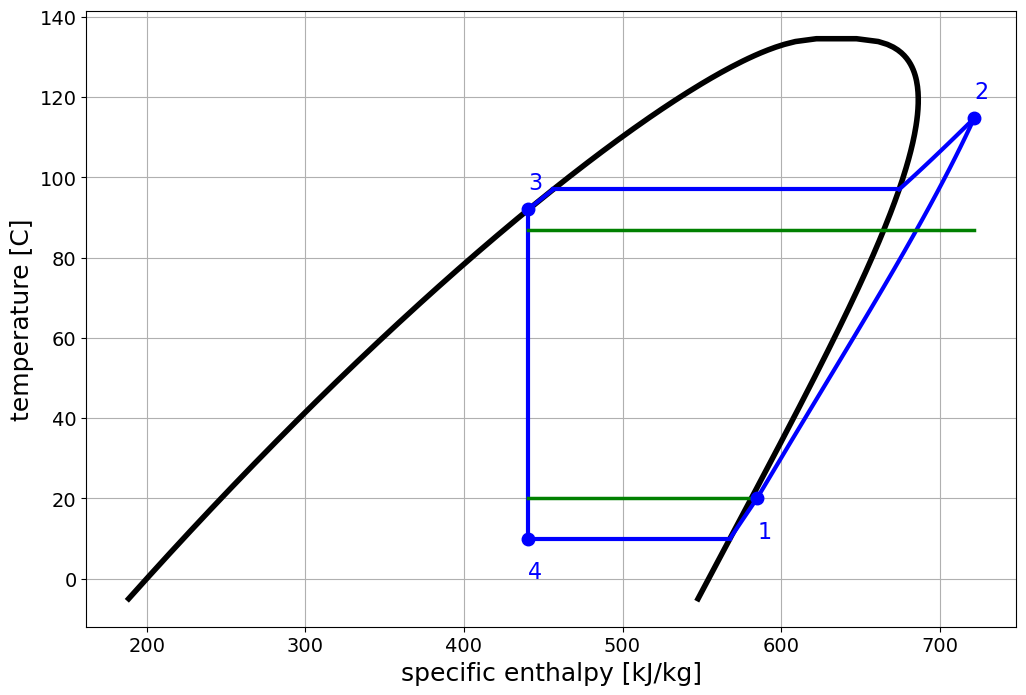

In [21]:
#thermodynamic states of the heat pump process as a function of the optimal evaporation and condensation temperatures
#state1_sat_op: evaporator: T1=T_ev_op and x1=1.0 (saturated vapor)

hp_evals = HP((T_co_op,T_ev_op))

state1_sat_op=hp_evals["state1_sat"]

#state1_op: outlet evaporator: T1=T_ev_op+delta_T_sh and p1=p1_sat
state1_op = hp_evals["state1"]

#state3_sat_op: outlet condenser: T3=T_co_op and x3=0.0 (boiling liquid)
state3_sat_op= hp_evals["state3_sat"]
#state3_op: outlet condenser: T3=T_co_op-delta_T_sc and p3=p3_stat
state3_op= hp_evals["state3"]
# State 3x: dewpoint at condenser pressure (x = 1)

state3x_op = hp_evals["state3x"]

eta_is = hp_evals["eta_is"]
m_dot = hp_evals["m_dot"]

#state2s_op: isentropic compressor: p2s=p_co=p3 and s2s=s1 
state2s_op= hp_evals["state2s"]
#enthalpy h2 is calulated using the compressor efficiency eta_is
h2_op= hp_evals["h2"]
#state2_op: outlet compressor: p2=p_co=p3 and h2
state2_op= hp_evals["state2"]
#state4_op: outlet throttle: p4=p_ev=p1 and h4=h3 (isenthalpic throttle)
state4_op= hp_evals["state4"]

Q_con_sh = m_dot*(h2_op-state3x_op['h']) #kW
Q_con_lat =m_dot*(state3x_op["h"]-state3_sat_op["h"]) #kW
Q_con_sc = m_dot*(state3_sat_op['h'] - state3_op['h'])

P_in = (Q_con_sh + Q_con_lat + Q_con_sc) / COP

print("Heat for condensing superheat=",round(Q_con_sh,2),"kW")
print("Heat for condensing latent=",round(Q_con_lat,2),"kW")
print("Heat for condensing subcooling=",round(Q_con_sc,2),"kW")
print("Heat in= ",round(Q_con_sh+Q_con_lat+Q_con_sc,2),"kW")
print("Work in=", P_in)

T3sat = state3_sat_op['T']
T3x = state3x_op['T']
T2 = state2_op['T']
 
T_water_worst_case = T_si_in 

deltaT_m_sc=((T3sat - T_water_worst_case) - ((T3sat - delta_T_sc)- T_water_worst_case))/(np.log((T3sat - T_water_worst_case)/((T3sat - delta_T_sc) - T_water_worst_case )))
deltaT_m_sh=((T2 - T_water_worst_case) - (T3x - T_water_worst_case))/(np.log((T2 - T_water_worst_case)/(T3x - T_water_worst_case))) 

L_con_sc = Q_con_sc*1000*R_L_sc/(deltaT_m_sc)
L_con_lat = Q_con_lat*1000*R_L_lat/(T3sat - T_water_worst_case)
L_con_sh = Q_con_sh*1000*R_L_sh/(deltaT_m_sh)

print("Tube length for condensing superheating= ",round(L_con_sh,2),"m")
print("Tube length for condensing latent= ",round(L_con_lat,2),"m")
print("Tube length for condensing subcooling= ",round(L_con_sc,2),"m")
L_t=L_con_sc+L_con_lat+L_con_sh
print("Total length of condenser tube=",round(L_t,2),"m")
print("optimized condensation temperature= ",round(T_co_op,2),"°C")
print("optimized evaporation temperature= ",round(T_ev_op,2),"°C")

Diag.Th(state1_op,state2_op,state3_op,state4_op,[T_si_in,T_si_out],[T_so_in,T_so_out],fluid,Eh)

### Optimizing Heatpump for all possible Refrigerants / Compressors with specified nominal Q for worst case 

In [12]:
#find the optimal lengths for defined nominal heat output of 3661.6 kW at 87 degrees sink temperature
#found through worst case scenario analysis

T_si_in = 87

nominal_Q = 3661.1 / 1000

optimal_lengths = {}

for i in diameters:
    _D = i
    optimal_lengths[_D] = {}

    for j in refrigerants:
        fluid = j
        optimal_lengths[_D][fluid] = {}

        bounds = [(T_si_in, np.inf), (-np.inf, T_so_in)]

        NC1 = NonlinearConstraint(pinch_evap, [min_pinch, min_pinch], [np.inf, min_pinch])
        NC2 = NonlinearConstraint(pinch_con, [min_pinch,min_pinch,min_pinch], [np.inf,np.inf,np.inf])
        NC3a = NonlinearConstraint(lambda x: [calc_spec_length(x)[0]], [0], [np.inf])
        NC3b = NonlinearConstraint(lambda x: [calc_spec_length(x)[1]], [nominal_Q], [nominal_Q])

        NCs = [NC1, NC2, NC3a, NC3b]

        T_co_start = T_si_in + 10  # °C
        T_ev_start = T_so_in - 10  # °C
        

        Opti = minimize(calc_COP, x0=[T_co_start, T_ev_start],
                        method='SLSQP', bounds=bounds, constraints=NCs)
        
        if not Opti.success:
                print("⚠️ Optimization failed for this T_si_in")
                continue

        COP = 1. / calc_COP(Opti.x)

        T_co_op, T_ev_op = Opti.x
        
        #thermodynamic states of the heat pump process as a function of the optimal evaporation and condensation temperatures
        #state1_sat_op: evaporator: T1=T_ev_op and x1=1.0 (saturated vapor)

        hp_evals = HP((T_co_op,T_ev_op))

        state1_sat_op=hp_evals["state1_sat"]

        #state1_op: outlet evaporator: T1=T_ev_op+delta_T_sh and p1=p1_sat
        state1_op = hp_evals["state1"]

        #state3_sat_op: outlet condenser: T3=T_co_op and x3=0.0 (boiling liquid)
        state3_sat_op= hp_evals["state3_sat"]
        #state3_op: outlet condenser: T3=T_co_op-delta_T_sc and p3=p3_stat
        state3_op= hp_evals["state3"]
        # State 3x: dewpoint at condenser pressure (x = 1)

        state3x_op = hp_evals["state3x"]

        eta_is = hp_evals["eta_is"]
        m_dot = hp_evals["m_dot"]

        #state2s_op: isentropic compressor: p2s=p_co=p3 and s2s=s1 
        state2s_op= hp_evals["state2s"]
        #enthalpy h2 is calulated using the compressor efficiency eta_is
        h2_op= hp_evals["h2"]
        #state2_op: outlet compressor: p2=p_co=p3 and h2
        state2_op= hp_evals["state2"]
        #state4_op: outlet throttle: p4=p_ev=p1 and h4=h3 (isenthalpic throttle)
        state4_op= hp_evals["state4"]

        Q_con_sh = m_dot*(h2_op-state3x_op['h']) #kW
        Q_con_lat =m_dot*(state3x_op["h"]-state3_sat_op["h"]) #kW
        Q_con_sc = m_dot*(state3_sat_op['h'] - state3_op['h'])

        Q_t = Q_con_sh + Q_con_lat + Q_con_sc

        P_in = (Q_con_sh + Q_con_lat + Q_con_sc) / COP

        T3sat = state3_sat_op['T']
        T3x = state3x_op['T']
        T2 = state2_op['T']
        
        T_water_worst_case = T_si_in 

        deltaT_m_sc=((T3sat - T_water_worst_case) - ((T3sat - delta_T_sc)- T_water_worst_case))/(np.log((T3sat - T_water_worst_case)/((T3sat - delta_T_sc) - T_water_worst_case )))
        deltaT_m_sh=((T2 - T_water_worst_case) - (T3x - T_water_worst_case))/(np.log((T2 - T_water_worst_case)/(T3x - T_water_worst_case))) 

        L_con_sc = Q_con_sc*1000*R_L_sc/(deltaT_m_sc)
        L_con_lat = Q_con_lat*1000*R_L_lat/(T3sat - T_water_worst_case)
        L_con_sh = Q_con_sh*1000*R_L_sh/(deltaT_m_sh)

        L_t=L_con_sc+L_con_lat+L_con_sh
    
        optimal_lengths[_D][fluid] = {
                'COP': round(float(COP), 2),
                'length': round(float(L_t), 3),
                'heat': round(float(Q_t),3)
            }

Heat for condensing superheat= 0.63 kW
Heat for condensing latent= 2.89 kW
Heat for condensing subcooling= 0.21 kW
Heat out=  3.73 kW
Work in=  1.81 kW
Tube length for condensing superheating=  11.23 m
Tube length for condensing latent=  24.84 m
Tube length for condensing subcooling=  3.26 m
Total length of condenser tube= 39.32 m
Heat for condensing superheat= 0.63 kW
Heat for condensing latent= 2.89 kW
Heat for condensing subcooling= 0.21 kW
Heat out=  3.73 kW
Work in=  1.81 kW
Tube length for condensing superheating=  11.23 m
Tube length for condensing latent=  24.84 m
Tube length for condensing subcooling=  3.26 m
Total length of condenser tube= 39.32 m
Heat for condensing superheat= 0.63 kW
Heat for condensing latent= 2.89 kW
Heat for condensing subcooling= 0.21 kW
Heat out=  3.73 kW
Work in=  1.81 kW
Tube length for condensing superheating=  11.23 m
Tube length for condensing latent=  24.84 m
Tube length for condensing subcooling=  3.26 m
Total length of condenser tube= 39.32 m
H

C:\Users\aless\AppData\Local\Temp\ipykernel_1792\2685818422.py:41: RuntimeWarning: divide by zero encountered in log
  deltaT_m_sc=((T3sat - T_si_in) - ((T3sat - delta_T_sc)- T_si_in))/(np.log((T3sat - T_si_in)/((T3sat - delta_T_sc) - T_si_in )))
C:\Users\aless\AppData\Local\Temp\ipykernel_1792\2685818422.py:42: RuntimeWarning: divide by zero encountered in scalar divide
  deltaT_m_sh=((T2 - T_water_worst_case) - (T3x - T_water_worst_case))/(np.log((T2 - T_water_worst_case)/(T3x - T_water_worst_case)))
C:\Users\aless\AppData\Local\Temp\ipykernel_1792\2685818422.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  L_con_sc = Q_con_sc*1000*R_L_sc/(deltaT_m_sc)
C:\Users\aless\AppData\Local\Temp\ipykernel_1792\2685818422.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  L_con_lat = Q_con_lat*1000*R_L_lat/(T3sat - T_water_worst_case)
C:\Users\aless\AppData\Local\Temp\ipykernel_1792\2685818422.py:46: RuntimeWarning: divide by zero encountered in scalar divi

Heat for condensing superheat= 0.51 kW
Heat for condensing latent= 2.49 kW
Heat for condensing subcooling= 0.13 kW
Heat out=  3.12 kW
Work in=  1.3 kW
Tube length for condensing superheating=  inf m
Tube length for condensing latent=  inf m
Tube length for condensing subcooling=  -inf m
Total length of condenser tube= nan m
Heat for condensing superheat= 0.51 kW
Heat for condensing latent= 2.49 kW
Heat for condensing subcooling= 0.13 kW
Heat out=  3.12 kW
Work in=  1.3 kW
Tube length for condensing superheating=  137.19 m
Tube length for condensing latent=  14365827201.58 m
Tube length for condensing subcooling=  nan m
Total length of condenser tube= nan m
Heat for condensing superheat= 0.51 kW
Heat for condensing latent= 2.49 kW
Heat for condensing subcooling= 0.13 kW
Heat out=  3.12 kW
Work in=  1.3 kW
Tube length for condensing superheating=  inf m
Tube length for condensing latent=  inf m
Tube length for condensing subcooling=  -inf m
Total length of condenser tube= nan m


C:\Users\aless\AppData\Local\Temp\ipykernel_1792\2685818422.py:41: RuntimeWarning: invalid value encountered in log
  deltaT_m_sc=((T3sat - T_si_in) - ((T3sat - delta_T_sc)- T_si_in))/(np.log((T3sat - T_si_in)/((T3sat - delta_T_sc) - T_si_in )))


Heat for condensing superheat= 0.51 kW
Heat for condensing latent= 2.49 kW
Heat for condensing subcooling= 0.13 kW
Heat out=  3.12 kW
Work in=  1.3 kW
Tube length for condensing superheating=  inf m
Tube length for condensing latent=  inf m
Tube length for condensing subcooling=  -inf m
Total length of condenser tube= nan m
Heat for condensing superheat= 0.51 kW
Heat for condensing latent= 2.49 kW
Heat for condensing subcooling= 0.13 kW
Heat out=  3.12 kW
Work in=  1.3 kW
Tube length for condensing superheating=  137.19 m
Tube length for condensing latent=  14365827201.58 m
Tube length for condensing subcooling=  nan m
Total length of condenser tube= nan m
Heat for condensing superheat= 0.51 kW
Heat for condensing latent= 2.49 kW
Heat for condensing subcooling= 0.13 kW
Heat out=  3.12 kW
Work in=  1.3 kW
Tube length for condensing superheating=  inf m
Tube length for condensing latent=  inf m
Tube length for condensing subcooling=  -inf m
Total length of condenser tube= nan m
Heat for 

KeyboardInterrupt: 

In [14]:
optimal_lengths

{35: {'Isobutane': {'COP': 2.17, 'length': 66.15, 'heat': 3.866},
  'Butane': {'COP': 2.22, 'length': 53.025, 'heat': 2.904},
  'Isobutene': {'COP': 2.29, 'length': 66.141, 'heat': 3.665},
  'DimethylEther': {'COP': 2.22, 'length': 66.15, 'heat': 7.077}},
 40: {'Isobutane': {'COP': 2.11, 'length': 66.15, 'heat': 4.931},
  'Butane': {'COP': 2.22, 'length': 66.15, 'heat': 3.783},
  'Isobutene': {'COP': 2.24, 'length': 66.15, 'heat': 4.697},
  'DimethylEther': {'COP': 2.12, 'length': 66.15, 'heat': 8.889}},
 45: {'Isobutane': {'COP': 2.05, 'length': 66.15, 'heat': 6.068},
  'Butane': {'COP': 2.18, 'length': 66.15, 'heat': 4.7},
  'Isobutene': {'COP': 2.18, 'length': 66.15, 'heat': 5.805},
  'DimethylEther': {'COP': 2.01, 'length': 66.15, 'heat': 10.735}},
 50: {'Isobutane': {'COP': 1.98, 'length': 66.15, 'heat': 7.255},
  'Butane': {'COP': 2.13, 'length': 66.15, 'heat': 5.675},
  'Isobutene': {'COP': 2.12, 'length': 66.15, 'heat': 6.972},
  'DimethylEther': {'COP': 1.89, 'length': 66.15, 

In [15]:
results = {}  # Nested dictionary to store everything

for i in diameters:
    _D = i
    results[_D] = {}  # Create entry for this diameter

    for j in refrigerants:
        fluid = j

        results[_D][fluid] = {}

        max_length_condenser = 39.69

        # Temporary storage for this combination
        COP_DATA = []
        HEAT_DATA = {}  # Dictionary to store heat output data

        T_si_in_values = np.linspace(20, 93, 15)  # °C sink temperatures

        for T_si_in_val in T_si_in_values:
            T_si_in = T_si_in_val
            T_si_out = T_si_in_val  # assuming parallel flow

            print(f"Calculating COP for D = {i} mm, fluid = {j}, T_si_in = {T_si_in_val:.1f} °C")

            bounds = [(T_si_in_val, np.inf), (-np.inf, T_so_in)]

            NC1 = NonlinearConstraint(pinch_evap, [min_pinch, min_pinch], [np.inf, np.inf])
            NC2 = NonlinearConstraint(pinch_con, [min_pinch, min_pinch, min_pinch], [np.inf,np.inf,np.inf])
            NC3a = NonlinearConstraint(lambda x: [calc_spec_length(x)[0]], [max_length_condenser], [max_length_condenser])
            
            NCs = [NC1, NC2, NC3a]

            T_co_start = T_si_in_val + 10
            T_ev_start = T_so_in - 10

            Opti = minimize(calc_COP, x0=[T_co_start, T_ev_start], method='SLSQP', bounds=bounds, constraints=NCs)

            if not Opti.success:
                print("⚠️ Optimization failed for this T_si_in")
                continue

            COP = 1. / calc_COP(Opti.x)
            print(f"  → Optimized COP = {round(COP, 2)}")

            T_co_op, T_ev_op = Opti.x

            COP_DATA.append((T_si_in_val, COP))
            _, Q_hp_W = calc_spec_length((T_co_op, T_ev_op))
            HEAT_DATA[T_si_in_val] = Q_hp_W

        # Store the results in the main dictionary
        results[_D][fluid][max_length_condenser] = {
            "COP_DATA": COP_DATA,
            "HEAT_DATA": HEAT_DATA
        }

        # Optional: generate your fit functions after storing

Calculating COP for D = 35 mm, fluid = Isobutane, T_si_in = 20.0 °C
Heat for condensing superheat= 0.8 kW
Heat for condensing latent= 6.19 kW
Heat for condensing subcooling= 0.23 kW
Heat out=  7.22 kW
Work in=  0.98 kW
Tube length for condensing superheating=  13.04 m
Tube length for condensing latent=  53.19 m
Tube length for condensing subcooling=  3.6 m
Total length of condenser tube= 69.83 m
Heat for condensing superheat= 0.8 kW
Heat for condensing latent= 6.19 kW
Heat for condensing subcooling= 0.23 kW
Heat out=  7.22 kW
Work in=  0.98 kW
Tube length for condensing superheating=  13.04 m
Tube length for condensing latent=  53.19 m
Tube length for condensing subcooling=  3.6 m
Total length of condenser tube= 69.83 m
Heat for condensing superheat= 0.8 kW
Heat for condensing latent= 6.19 kW
Heat for condensing subcooling= 0.23 kW
Heat out=  7.22 kW
Work in=  0.98 kW
Tube length for condensing superheating=  13.04 m
Tube length for condensing latent=  53.19 m
Tube length for condensin

In [16]:
def write_heat_pump_results(results, filename="heat_pump_results.txt"):
    with open(filename, "w") as f:
        for diameter, fluids in results.items():
            for fluid, length_dict in fluids.items():
                for length, data in length_dict.items():
                    f.write(f"DIA={diameter}, FLUID={fluid}, LENGTH={round(length, 3)}\n")

                    # --- Write COP data ---
                    f.write("COP_DATA:\n")
                    for T, cop in data["COP_DATA"]:
                        f.write(f"{float(T):.2f}, {float(cop):.4f}\n")

                    # --- Write heat output data ---
                    f.write("HEAT_DATA:\n")
                    for T, Q in data["HEAT_DATA"].items():
                        f.write(f"{float(T):.2f}, {float(Q):.2f}\n")

                    f.write("END_ENTRY\n\n")

In [17]:
write_heat_pump_results(results)